# Statistical Analysis of TOKIO-ABC Results

This notebook performs various statistical analyses of the summary data generated by each TOKIO-ABC job.  These data are loaded from __a summary csv file__ where each row represents a single job and contains the relevant data extracted from

1. the darshan log
2. the server-side I/O monitoring (Lustre LMT or GPFS GGIOSTAT)
3. optional system-specific monitoring including
    - OST health info (Lustre)
    - Concurrent job count (Slurm)
    - Job radius (Cray XC)
    
This input CSV is generated at NERSC by

1. running `utils/nersc_generate_job_summary.sh` to generate json summary records for each darshan log
2. running `utils/json2csv.py` to convert all jsons into a single csv file

This script is used to identify interesting patterns and correlations across jobs.  For intra-job inspection, use other analysis notebooks such as `analysis/per_ost_deep_dive.ipynb`.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
plt.rcParams['image.cmap'] = 'gray'
import matplotlib.gridspec
import os

In [2]:
import pandas
import numpy as np
import scipy
import scipy.stats as stats
import scipy.interpolate
import json
import datetime
import bisect
import warnings
import textwrap

### black magic necessary for processing Mira log files :(
try:
    import pytz
    _USE_TZ = True
except ImportError:
    _USE_TZ = False

def wrap(text, width=15):
    """wrapper for the wrapper"""
    return '\n'.join(textwrap.wrap(text=text,width=width))

In [3]:
def utc_timestamp_to_argonne( timestamp ):
    """
    This is a batty function that allows us to compare the UTC-based
    timestamps from Darshan logs (start_time and end_time) to the
    Chicago-based YYYY-MM-DD dates used to index the mmdf data.
    """
    if _USE_TZ:
        ### we know that these logs are from Chicago
        tz = pytz.timezone("America/Chicago")
        
        ### Darshan log's start time in UTC, so turn it into a datetime with UTC on it
        darshan_time = pytz.utc.localize(datetime.datetime.utcfromtimestamp(timestamp))
        
        ### Then convert this UTC start time into a local start time so
        ### we can compare it to the local mmdf timestamp
        darshan_time_at_argonne = darshan_time.astimezone(tz)
        return darshan_time_at_argonne
    else:
        ### we assume that this script is running on Argonne time; it's the best we can do
        warnings.warn("pytz is not available so mmdf data might be misaligned by a day!")
        return datetime.datetime.fromtimestamp(timestamp)

In [4]:
### Relative path to the repository's root directory
_REPO_BASE_DIR = os.path.join('..', '..')

### Translates cryptic counter names into something suitable for labeling plots
counter_labels = json.load(open(os.path.join(_REPO_BASE_DIR, 'scripts', 'counter_labels.json'), 'r'))

### For consistency, always plot file systems in the same order
_FILE_SYSTEM_ORDER = [ 'scratch1', 'scratch2', 'scratch3', 'mira-fs1' ]

_INPUT_EDISON_DATA_CSV = os.path.join(_REPO_BASE_DIR,
                                      'data',
                                      'dat',
                                      'tokio-lustre',
                                      'edison-abc-stats_2-14_3-28_v2.csv')
_INPUT_MIRA_DATA_CSV = os.path.join(_REPO_BASE_DIR,
                                    'data',
                                    'dat',
                                    'tokio-gpfs',
                                    'alcf-abc-stats_2-25_3-27.dat')
_INPUT_MIRA_MMDF_CSV = os.path.join(_REPO_BASE_DIR,
                                    'data',
                                    'dat',
                                    'tokio-gpfs',
                                    'mira_mmdf_1-25_3-27.csv')

_COVERAGE_FACTOR_CUTOFF = 1.2

_MIRA_JOBS_BLACKLIST = [ 1039807 ]

In [5]:
### This is a time range that encompasses data collected on both Edison and Mira

# start time is inclusive
_START_TIME = datetime.datetime(2017, 2, 24, 0, 0, 0)
# end time is exclusive
_END_TIME   = datetime.datetime(2017, 3, 26, 0, 0, 0)
# _START_TIME = _END_TIME = None

In [6]:
### All time

# start time is inclusive
_START_TIME = datetime.datetime(2016, 2, 24, 0, 0, 0)
# end time is exclusive
_END_TIME   = datetime.datetime(2017, 3, 26, 0, 0, 0)
# _START_TIME = _END_TIME = None

## Load data

We've been storing most of the per-job summary data in a single CSV per system.  We

1. Load the CSV directly into a dataframe
2. Drop any rows containing NANs, because if any of the core data is missing (e.g., application name), the whole record is useless.  Hopefully I haven't overlooked anything important in this assumption.
3. Synthesize a few new columns (we call these "metrics" in the paper) to facilitate downstream analysis

In [7]:
### Edison
df_edison = pandas.DataFrame.from_csv(_INPUT_EDISON_DATA_CSV).dropna()
df_edison['darshan_rw'] = [ 'write' if x == 1 else 'read' for x in df_edison['darshan_write_mode?'] ]
df_edison['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_edison['darshan_api'] ]
df_edison.rename(columns={'lmt_bytes_covered': 'coverage_factor'}, inplace=True)
df_edison['system'] = "edison"
df_edison['iops_coverage_factor'] = -1.0
df_edison['nodehr_coverage_factor'] = df_edison['job_num_nodes'] * \
                                      (df_edison['darshan_end_time'] - df_edison['darshan_start_time']) / 3600.0 / \
                                      (df_edison['job_concurrent_nodehrs'])


### Mira
df_mira = pandas.DataFrame.from_csv(_INPUT_MIRA_DATA_CSV).dropna()
rename_dict = { '# platform': "system" }
for key in df_mira.keys():
    if key == 'file_sys':
        rename_dict[key] = 'darshan_file_system'
    elif key not in rename_dict and not key.startswith('ggio_'):
        rename_dict[key] = 'darshan_' + key
df_mira.rename(columns=rename_dict, inplace=True)
df_mira['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_mira['darshan_api'] ]
df_mira['coverage_factor'] = df_mira['darshan_total_bytes'] / (df_mira['ggio_bytes_read'] + df_mira['ggio_bytes_written'])
df_mira['iops_coverage_factor'] = (df_mira['darshan_total_rws'] / (df_mira['ggio_read_reqs'] + df_mira['ggio_write_reqs']))
df_mira['nodehr_coverage_factor'] = -1.0

Because I'm lazy, load the `mmdf` data separately and attach it to `df_mira`.  The mmdf CSV is generated by

1. retrieving all of the `df_fs1_*.txt` files from `mira:/projects/radix-io/automated/runs/gpfs-logs/`
2. running `tokio-cron-benchmarks:utils/parse_mmdf.py` script against `df_fs1_*.txt` (note that although `parse_mmdf.py` can distinguish between different file systems, this script currently doesn't filter for the correct `file_system` column

In [8]:
df_mmdf = pandas.DataFrame.from_csv(_INPUT_MIRA_MMDF_CSV, index_col=['file_system', 'date'])
df_mmdf['free_kib'] = df_mmdf['free_kib_blocks'] + df_mmdf['free_kib_frags']
df_mmdf['free_pct'] = df_mmdf['free_kib'] / df_mmdf['disk_size']

Walk the master dataframe and attach mmdf data.  Note that we're injecting NAs for missing mmdf data because missing mmdf data should not exclude the entire day from our analysis.

In [9]:
### I really hope iterrows behaves deterministically and preserves order...
new_data = {
    'mmdf_avg_fullness_pct': [],
    'mmdf_max_fullness_pct': [],
}

### iterate over each row of the master Mira dataframe
no_data = set([])
for row in df_mira.itertuples():
    fs_key = row.darshan_file_system
    mmdf_key = utc_timestamp_to_argonne( row.darshan_start_time ).strftime("%Y-%m-%d")
    if mmdf_key in df_mmdf.loc[fs_key].index:
        ### only look at today's data
        df = df_mmdf.loc[fs_key].loc[mmdf_key]
        
        data_cols = [ True if x else False for x in df['data?'] ]

        ### calculate a percent fullness - don't bother saving the id of this fullest server though
        new_data['mmdf_max_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].min() )
        new_data['mmdf_avg_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].mean() )
    else:
        no_data.add( datetime.datetime.fromtimestamp(row.darshan_start_time).strftime("%Y-%m-%d") )
        new_data['mmdf_max_fullness_pct'].append( np.nan )
        new_data['mmdf_avg_fullness_pct'].append( np.nan )

warnings.warn("No MMDF data found for the following dates:\n" + '\n'.join(no_data))
        
for new_col_name, new_col_data in new_data.iteritems():
    df_mira[new_col_name] = new_col_data

/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: UserWarning: No MMDF data found for the following dates:
2017-02-26
2017-02-24


Now merge both DataFrames so we can look at all the data if we really want to.  This DataFrame will have a bunch of NANs for data that is only applicable to Mira or Edison.

In [10]:
df_concat = pandas.concat( (df_mira, df_edison) )

## Filter Data

Two notable filters are applied:

1. All jobs where the bytes coverage factor and ops coverage factor are greater than 1.2 are discarded because they reflect severely misaligned or gappy data.

2. Mira job 1039807 is excluded because ggiostat returned highly abnormal results starting that day.  See e-mail from Shane and Phil on March 23 about this.

3. All Edison jobs from March 12 were discarded because LMT broke as a result of daylight saving time rolling over.  This filter was applied _before_ the input CSV files loaded above were generated, so it does not need to be applied here.

In [11]:
for df in df_mira, df_edison, df_concat:
    print '+'.join( df['system'].unique() )
    print ''.join([ '=' * 50])
    
    count = len(df)
    df.drop(df.index[df['coverage_factor'] > _COVERAGE_FACTOR_CUTOFF], inplace=True)
    print "Dropped %d records due to coverage factor > %.1f" % (count - len(df), _COVERAGE_FACTOR_CUTOFF)
    
    count = len(df)
    for blacklisted_job in _MIRA_JOBS_BLACKLIST:
        df.drop(df.index[(df['system'] == 'mira') & (df['darshan_jobid'] == blacklisted_job)], inplace=True)
    print "Dropped %d records due to Mira job #1039807" % (count - len(df))

    count = len(df)
    if _END_TIME is not None and _START_TIME is not None:
        filter_time = [ datetime.datetime.fromtimestamp(df['darshan_start_time'][x]) < _START_TIME                    
                        or
                        datetime.datetime.fromtimestamp(df['darshan_start_time'][x]) > _END_TIME
                        for x in df.index ]
        df.drop(df.index[filter_time], inplace=True)
    print "Dropped %d records outside of time range %s - %s" % (count - len(df), _START_TIME, _END_TIME)
    print "Total measurements to be analyzed:", len(df)
    print

mira
Dropped 96 records due to coverage factor > 1.2
Dropped 8 records due to Mira job #1039807
Dropped 0 records outside of time range 2016-02-24 00:00:00 - 2017-03-26 00:00:00
Total measurements to be analyzed: 118

edison
Dropped 0 records due to coverage factor > 1.2
Dropped 0 records due to Mira job #1039807
Dropped 72 records outside of time range 2016-02-24 00:00:00 - 2017-03-26 00:00:00
Total measurements to be analyzed: 1014

mira+edison
Dropped 96 records due to coverage factor > 1.2
Dropped 8 records due to Mira job #1039807
Dropped 72 records outside of time range 2016-02-24 00:00:00 - 2017-03-26 00:00:00
Total measurements to be analyzed: 1132



In [12]:
for df in df_mira, df_edison, df_concat:
    print '+'.join( df['system'].unique() )
    print ''.join([ '=' * 50])
    print "Earliest timestamp now", datetime.datetime.fromtimestamp(df['darshan_start_time'].min())
    print "Latest timestamp now", datetime.datetime.fromtimestamp(df['darshan_start_time'].max())
    print

mira
Earliest timestamp now 2017-02-24 20:17:41
Latest timestamp now 2017-03-25 18:17:05

edison
Earliest timestamp now 2017-02-14 09:29:40
Latest timestamp now 2017-03-25 03:44:05

mira+edison
Earliest timestamp now 2017-02-14 09:29:40
Latest timestamp now 2017-03-25 18:17:05



## Normalize Performance
Different file systems, benchmarks, and read/write modes are capable of different peak bandwidths.  As such, we want to normalize the absolute performance (`summarize_key`) by something.  For convenience we calculate the denominator for normalization a couple of different ways (e.g., the mean, median, and max measurement).  We also limit normalization to unique combinations of variables specified by `normalization_group` below.

Calculate the normalization factors (the denominators), then apply that factor to all of the data in the DataFrame.  These normalized data will be saved as new columns in the DataFrame.

In [13]:
### The actual variable we want to normalize
summarize_key = 'darshan_agg_perf_by_slowest'

for df in df_edison, df_mira, df_concat:
    ### Specify which keys we want to group together before normalizing
    normalization_group = df.groupby(['darshan_app', 'darshan_file_system', 'darshan_file_mode', 'darshan_rw'])

    ### Dict to store the denominators for normalization
    normalization_data = {
        'mean':   normalization_group.darshan_agg_perf_by_slowest.mean(),
        'median': normalization_group.darshan_agg_perf_by_slowest.median(),
        'max':    normalization_group.darshan_agg_perf_by_slowest.max(),
    }

    ### Normalize every row in the DataFrame by all of our denominators
    new_cols = {}
    for func in normalization_data.keys():
        new_col_key = 'darshan_normalized_perf_by_%s' % func
        new_cols[new_col_key] = []
        for index, row in df.iterrows():
            new_cols[new_col_key].append(
                row[summarize_key] / normalization_data[func]
                                                       [row['darshan_app']]
                                                       [row['darshan_file_system']]
                                                       [row['darshan_file_mode']]
                                                       [row['darshan_rw']]
            )

    ### Also just do per-file system
    normalization_group = df.groupby('darshan_file_system')
    normalization_data = {
        'mean':   normalization_group.darshan_agg_perf_by_slowest.mean(),
        'median': normalization_group.darshan_agg_perf_by_slowest.median(),
        'max':    normalization_group.darshan_agg_perf_by_slowest.max(),
    }
    for func in normalization_data.keys():
        new_col_key = 'darshan_normalized_perf_by_fs_%s' % func
        new_cols[new_col_key] = []
        for index, row in df.iterrows():
            new_cols[new_col_key].append(
                row[summarize_key] / normalization_data[func][row['darshan_file_system']])

    ### Take our normalized data and add them as new columns
    for new_col, new_col_data in new_cols.iteritems():
        df[new_col] = new_col_data

## Multivariate Correlation Analysis
`performance_key` is the variable we wish to use to represent performance.  It is typically

- `darshan_agg_perf_by_slowest`, which is the absolute performance measured by each benchmark run
- `darshan_normalized_perf_by_max`, which is normalized by the maximum observed performance
- `darshan_normalized_perf_by_mean`, which is normalized by the mean observed performance

In [14]:
performance_key = 'darshan_normalized_perf_by_max'

### Numerical Correlation Analysis

Pearson analysis assumes that each variable is normally distributed.  It is easier to understand, but it is not technically correct for variables that are _not_ normally distributed, which include performance.  The Spearman coefficient would be better and can be enabled below.

We use `scipy.stats` to calculate p-values associated with each correlation.  The ultimate artifact of this process is a table of interesting correlations, their correlation coefficients, and color coding to indicate the confidence of those coefficients based on p-values.

In [15]:
ignore_cols = [
    'lmt_tot_zeros',
    'lmt_frac_zeros',
    'lmt_frac_missing',
    'ost_avg_kib',
    'ost_min_pct',
    'ost_min_kib',
    'ost_max_kib',
    'ost_count',
#   'ost_bad_ost_count',
    'ost_bad_ost_pct',
    'ost_failures_lead_secs',
    'ost_fullness_lead_secs',
    'lmt_tot_missing',
    'ost_avg_bad_ost_per_oss',
    'ost_avg_bad_overload_factor',
    'ost_bad_oss_count',
    'ost_min_id',
    'ost_max_id',
    'job_min_radius',
    'job_avg_radius',
### second pass
    'lmt_ops_getattrs',
    'lmt_ops_getxattrs',
    'lmt_ops_rmdirs',
    'lmt_ops_unlinks',
    'lmt_ops_renames',
    'lmt_ops_setattrs',
    'lmt_ops_mkdirs',
    'ggio_inoded_updates',
### third pass
    "lmt_mds_ave",
    "lmt_oss_ave",
]

### if one key has the same logical meaning as another, this will remap those
### keys so they line up in the DataFrame
equivalent_keys = {
    'ggio_closes':     'lmt_ops_closes',
    'ggio_opens': 'lmt_ops_opens',
    'ggio_bytes_read': 'lmt_tot_bytes_read',
    'ggio_bytes_written': 'lmt_tot_bytes_write',
    'mmdf_max_fullness_pct': 'ost_max_pct',
    'mmdf_avg_fullness_pct': 'ost_avg_pct',
}

### Specific names for the table
counter_labels_table = {
    'coverage_factor': "Coverage Factor (Bandwidth)",
    'nodehr_coverage_factor': "Coverage Factor (NodeHrs)",
    "ost_avg_pct": "Avg LUN Fullness",
    "ost_max_pct": "Fullness on Fullest LUN",
    "lmt_oss_max": "Max CPU Load, Data Server",
    "ost_bad_pct": "% Servers Failed Over",
    "ost_bad_ost_count": "Failed-over Servers",
    "lmt_ops_closes": "close(2) Calls",
    "lmt_ops_opens": "open(2) Calls",
    "lmt_tot_bytes_write": "Bytes Written",
    "lmt_tot_bytes_read": "Bytes Read",
    "lmt_mds_max": "Max CPU Load, Metadata Server",
    "lmt_mds_ave": "Avg CPU Load, Metadata Server",
    "job_concurrent_jobs": "# Concurrent Jobs",
    "lmt_oss_ave": "Avg CPU Load, Data Server",
    "job_max_radius": "Job Diameter",
    "iops_coverage_factor": "Coverage Factor (IOPs)",
    "ggio_write_reqs": "Write Ops",
    "ggio_read_reqs": "Read Ops",
    "ggio_read_dirs": "readdir(3) Calls",
}

### Order in which table is to be printed
print_order = [
    'coverage_factor',
    'nodehr_coverage_factor',
    "iops_coverage_factor",
    "lmt_ops_closes",
    "lmt_ops_opens",
#   "ggio_read_dirs",
    "lmt_tot_bytes_write",
    "lmt_tot_bytes_read",
    "ggio_write_reqs",
    "ggio_read_reqs",
    "ost_max_pct",
    "ost_avg_pct",
    "lmt_mds_max",
    "lmt_oss_max",
    "ost_bad_ost_count",
    "job_concurrent_jobs",
#   "job_max_radius",
]

In [16]:
def correlation_calculation(df,
                            analysis_func=stats.pearsonr,
                            only_print_key=performance_key,
                            ignore_cols=[],
                            max_pval=1.01):
    """
    Calculate the Pearson correlation coefficient and the associated
    p-value for various counter pairs.  If only_print_key is None,
    every possible combination of columns in df is attempted; otherwise,
    the column identified by only_print_key is compared against all other
    columns.
    """
    num_cols = len(df.keys())
    results = []
    
    if only_print_key is None:
        i_range = range(num_cols - 1)
    else:
        i_range = [ list(df.columns).index(only_print_key) ]

    for i in i_range:
        i_col = df.columns[i]
        if only_print_key is None:
            j_range = range(i, num_cols)
        else:
            j_range = range(len(df.columns))
            j_range.remove(i_range[0]) # degenerate case
        for j in j_range:
            j_col = df.columns[j]
            try:
                ### The Scipy stats package barfs if x or y contain any
                ### NANs, but we don't want to drop all records that
                ### contain any nans.  So, we wait until the very last
                ### minute to drop only those columns that contain nans
                ### that we would otherwise try to correlate.
                df_corr = df[[i_col, j_col]].dropna()
                coeff, pval = analysis_func(df_corr[i_col],
                                            df_corr[j_col])
            except TypeError: # non-numeric column
                continue
            results.append((i_col,
                            j_col,
                            coeff,
                            pval))

    ### now start dropping correlations that we don't want/need
    sorted_results = sorted(results, key=lambda x: x[3])
    ret_results = []
    for col_name1, col_name2, coeff, pval in sorted_results:
        ### don't print trivial relationships
        if pval == 0 or pval == 1:
            continue
        ### don't print relationships with very high p-values
        if pval > max_pval:
            continue
        ### don't correlate data from the same source since much of it is degenerate
        if col_name1.split('_',1)[0] == col_name2.split('_',1)[0]:
            continue
        ### don't print anything except for the key of interest (if provided)
        if only_print_key is not None \
        and col_name1 != only_print_key \
        and col_name2 != only_print_key:
            continue
        if col_name1 in ignore_cols or col_name2 in ignore_cols:
            continue
#       print "%10.4f %10.4g %30s : %-15s" % (coeff, pval, col_name1, col_name2)
        
        ### sort the output key orders
        if col_name1 == only_print_key:
            ret_results.append([col_name1,col_name2,coeff,pval])
        elif col_name2 == only_print_key:
            ret_results.append([col_name2,col_name1,coeff,pval])
        else:
            if col_name2 > col_name1:
                ret_results.append([col_name1,col_name2,coeff,pval])
            else:
                ret_results.append([col_name2,col_name1,coeff,pval])
    return ret_results

In [17]:
def correlation_dict_to_dataframe(correlations):
    ### to_df: dict we will use to store arrays -> pd.Series
    to_df = {}

    ### common_key: needed to figure out which key is the independent variable
    common_key = None

    ### list that will become dataframe index
    key_index = []

    ### loop over all systems, all correlations, all pairs of variables
    for system, records in correlations.iteritems():
        for row in records:
            ### try to figure out which of the two keys is not repeated
            if common_key is None:
                common_key = row[0]
            if row[0] != common_key:
                common_key = row[1]
                unique_key = row[0]
            else:
                unique_key = row[1]

            ### convert compatible key names from ggio_ to lmt_
            if unique_key in equivalent_keys:
                unique_key = equivalent_keys[unique_key]

            ### build up a list of keys that will be our Index
            if unique_key not in key_index:
                key_index.append(unique_key)

            ### fill out the dict 
            counterkey = "counter_%s" % system
            corrkey = 'correlation_%s' % system
            pvalkey = 'p-value_%s' % system
            if counterkey not in to_df: to_df[counterkey] = []
            if corrkey not in to_df: to_df[corrkey] = []
            if pvalkey not in to_df: to_df[pvalkey] = []
            to_df[counterkey].append(unique_key)
            to_df[corrkey].append(row[2])
            to_df[pvalkey].append(row[3])

    ### Make an empty but indexed data frame
    df = pandas.DataFrame(index=key_index)
    for system in correlations.keys():
        counterkey = "counter_%s" % system
        corrkey = 'correlation_%s' % system
        pvalkey = 'p-value_%s' % system

        df[corrkey] = pandas.Series(to_df[corrkey], index=to_df[counterkey])
        df[pvalkey] = pandas.Series(to_df[pvalkey], index=to_df[counterkey])

    return df

In [18]:
### Calculate unconstrainted correlation table just for our edification
### Calculate correlations between performance and everything else
correlations = {}

correlations['edison'] = correlation_calculation(df_edison)
correlations['mira'] = correlation_calculation(df_mira)

correlation_dict_to_dataframe( correlations )

,correlation_edison,p-value_edison,correlation_mira,p-value_mira
job_concurrent_nodehrs,-0.612110,2.754145e-105,NaN,NaN
lmt_tot_zeros,-0.496931,2.384411e-64,NaN,NaN
coverage_factor,0.441805,1.077787e-49,0.243255,0.007948
lmt_frac_zeros,-0.394075,5.177596e-39,NaN,NaN
ost_avg_kib,-0.380742,2.512576e-36,NaN,NaN
ost_avg_pct,-0.380742,2.512576e-36,-0.033448,0.739847
ost_min_pct,-0.378347,7.406742e-36,NaN,NaN
ost_min_kib,-0.378347,7.406742e-36,NaN,NaN
ost_max_kib,-0.354434,2.219535e-31,NaN,NaN
ost_max_pct,-0.354434,2.219535e-31,-0.033569,0.738936


In [19]:
### Calculate correlations between a subset of interesting measurements
### so we can generate the correlation table
correlations = {}

correlations['edison'] = correlation_calculation(df_edison, ignore_cols=ignore_cols)
correlations['mira'] = correlation_calculation(df_mira, ignore_cols=ignore_cols)

df = correlation_dict_to_dataframe( correlations )
df

,correlation_edison,p-value_edison,correlation_mira,p-value_mira
job_concurrent_nodehrs,-0.612110,2.754145e-105,NaN,NaN
coverage_factor,0.441805,1.077787e-49,0.243255,0.007948
ost_avg_pct,-0.380742,2.512576e-36,-0.033448,0.739847
ost_max_pct,-0.354434,2.219535e-31,-0.033569,0.738936
lmt_oss_max,-0.233690,4.812935e-14,NaN,NaN
ost_bad_ost_count,0.173320,2.786005e-08,NaN,NaN
ost_bad_pct,0.173320,2.786005e-08,NaN,NaN
lmt_ops_closes,-0.107135,6.327574e-04,-0.226236,0.013762
lmt_ops_opens,-0.106543,6.783399e-04,-0.225946,0.013887
lmt_mds_max,-0.092827,3.089770e-03,NaN,NaN


                ggio_read_reqs pval=    0.0040; setting color to blue
                 lmt_ops_opens pval=    0.0139; setting color to green
                lmt_ops_closes pval=    0.0006; setting color to blue
               ggio_write_reqs pval=    0.0115; setting color to green
           job_concurrent_jobs pval=    0.1796; setting color to red
                   ost_avg_pct pval=    0.7398; setting color to red
                 lmt_ops_opens pval=    0.0007; setting color to blue
                   ost_max_pct pval=    0.0000; setting color to blue
                lmt_ops_closes pval=    0.0138; setting color to green
               coverage_factor pval=    0.0079; setting color to blue
            lmt_tot_bytes_read pval=    0.0732; setting color to red
           lmt_tot_bytes_write pval=    0.0038; setting color to blue
                   ost_avg_pct pval=    0.0000; setting color to blue
                   ost_max_pct pval=    0.7389; setting color to red
               covera

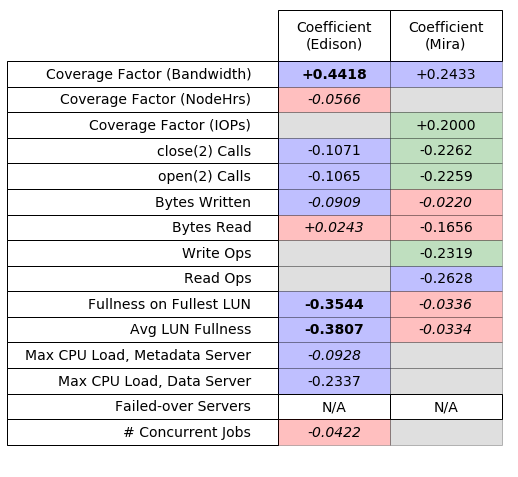

In [20]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(111)

column_headers = {
    "correlation_edison": "Coefficient\n(Edison)",
    "correlation_mira": "Coefficient\n(Mira)",
    "p-value_edison": "P-value (Edison)",
    "p-value_mira": "P-value (Mira)",
}

coefficient_keys = [x for x in df.columns if x.startswith('correlation_')]

### the index is column -1
table = pandas.tools.plotting.table(ax,
                            df[coefficient_keys].reindex(print_order),
                            loc='upper right',
                            colWidths=[0.8,0.8,3.8],
                            bbox=[0, 0, 1, 1])
table.set_fontsize(14)
ax.axis('tight')
ax.axis('off')

### Rewrite the contents of the table that Pandas gave us
cells_dict = table.get_celld()
remap_values = {}
for cell_pos, cell_obj in cells_dict.iteritems():
    i, j = cell_pos
    value = cell_obj.get_text().get_text()
    height_scale = 1.0
    if i == 0:    # column headers
        remap_values[cell_pos] = column_headers.get(value, value)
        height_scale = 2.0
    elif j == -1: # index cell
        remap_values[cell_pos] = counter_labels_table.get(value, value)
        cell_obj._loc = 'right'
    else:         # coefficient cell
        index = cells_dict[(i,-1)].get_text().get_text()
        column = cells_dict[(0,j)].get_text().get_text()
        cell_obj._loc = 'center'
        
        ### need a special handler for ost_bad_ost_count because Pearson
        ### will correlate against it even though it is invariant :(
        ### TODO: fix it so that we don't try to correlate against constants
        if index == 'ost_bad_ost_count':
            remap_values[cell_pos] = "N/A"
            cell_obj.set_color('white')
#           cell_obj._loc = 'center'
        elif value == "nan":
            cell_obj.set_color('grey')
            remap_values[cell_pos] = ""
            cell_obj.set_alpha(0.25)
#           cell_obj._loc = 'center'
        else:
            coeff = float(value)
            pval = df.loc[index][column.replace('correlation','p-value')]

            ### make moderate correlations **bold**
            if abs(coeff) >= 0.30:
                cell_obj.get_text().set_fontweight('bold')
            elif abs(coeff) < 0.10:
                cell_obj.get_text().set_fontstyle('italic')

            ### color code cells based on p-value
            if pval < 0.01:
                set_color = 'blue'
            elif pval < 0.05:
                set_color = 'green'
            else:
                set_color = 'red'
            
            ### for debugging, since the resulting figure doesn't contain any p-values
            print "%30s pval=%10.4f; setting color to %s" % (
                index, pval, set_color
            )
            cell_obj.set_color(set_color)
            cell_obj.set_alpha(0.25)
#           cell_obj._loc = 'center'
            remap_values[cell_pos] = "%+.4f" % coeff
    cell_obj.set_height(height_scale * cell_obj.get_height())
    cell_obj.set_edgecolor('black')

### Actually rewrite the cells now
for cell_pos, new_value in remap_values.iteritems():
    cells_dict[cell_pos].get_text().set_text(new_value)
    
output_file = "correlation_table.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

### Scatter Plots
To visualize these correlations, we define pairs of counters to plot against each other:

In [21]:
scatterplots = [ 
    ('edison', performance_key, 'coverage_factor'),
    ('mira', performance_key, 'coverage_factor'),
    ('mira', performance_key, 'iops_coverage_factor'),
    ('edison', performance_key, 'lmt_oss_max'),
    ('edison', performance_key, 'job_concurrent_jobs'),
    ('edison', performance_key, 'ost_avg_pct'),
    ('edison', performance_key, 'ost_max_kib'),
    ('mira', performance_key, 'ggio_write_reqs'),
    ('mira', performance_key, 'ggio_read_reqs'),

]

...and then plot them:

Saved scatter_darshan_normalized_perf_by_max_vs_coverage_factor.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_coverage_factor.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_iops_coverage_factor.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_lmt_oss_max.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_job_concurrent_jobs.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ost_avg_pct.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ggio_write_reqs.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ggio_read_reqs.pdf


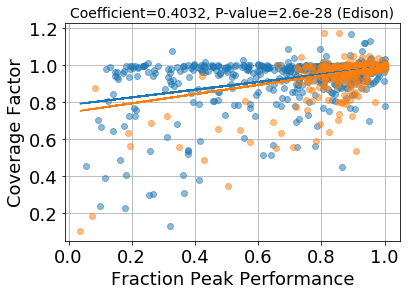

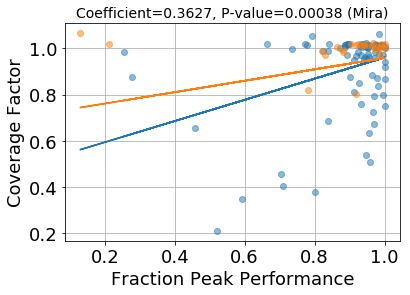

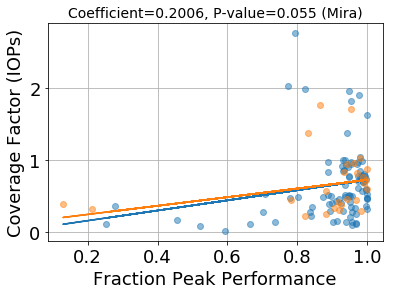

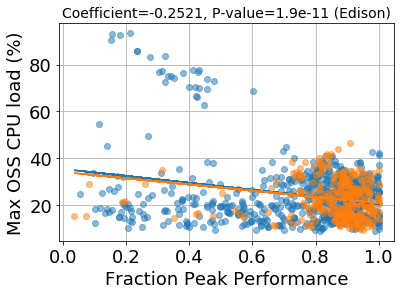

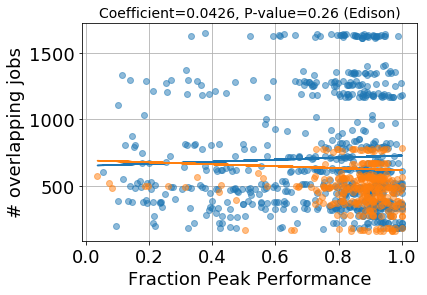

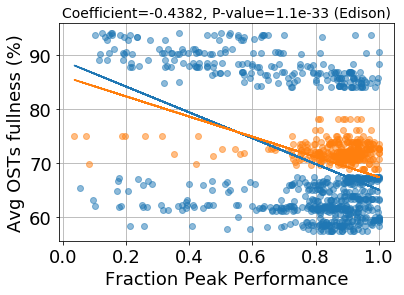

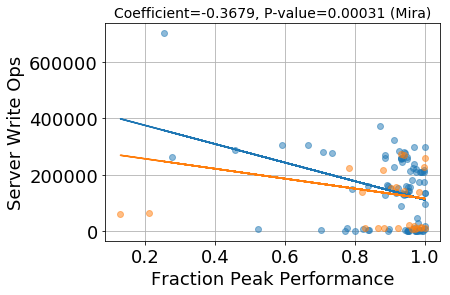

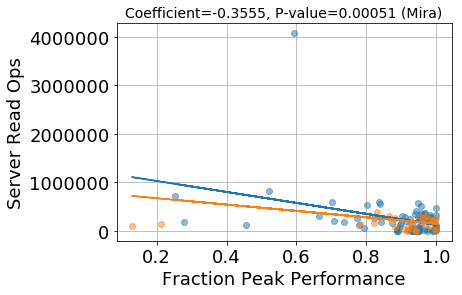

In [22]:
blacklist = set([
    'ost_max_id', 'ost_min_id', 'lmt_tot_zeros',
    'ost_failures_lead_secs', 'ost_fullness_lead_secs',
    'ost_max_kib', 'ost_avg_kib', 'ost_min_kib', 
    'lmt_tot_missing'
])
# for scatterplot in correlations_edison + correlations_mira:
for system, x_key, y_key in scatterplots:
    if x_key in blacklist or y_key in blacklist:
        continue
    if system == "edison":
        df_plot = df_edison
        system = "Edison"
    elif system == "mira":
        df_plot = df_mira
        system = "Mira"
    else:
        warnings.warn("Cannot do not understand system " + system)
        continue
        
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    
    x = df_plot[x_key].values
    x_label = counter_labels.get(x_key, x_key)
    y = df_plot[y_key].values
    y_label = counter_labels.get(y_key, y_key)
### tmp
    cutoff_time = datetime.datetime(2017, 3, 13, 0, 0, 0)
    df_plot['tmp'] = [datetime.datetime.fromtimestamp(df_plot['darshan_start_time'][i]) for i in df_plot.index]
    x1 = df_plot[df_plot['tmp'] < cutoff_time][x_key].values
    y1 = df_plot[df_plot['tmp'] < cutoff_time][y_key].values
    x2 = df_plot[df_plot['tmp'] >= cutoff_time][x_key].values
    y2 = df_plot[df_plot['tmp'] >= cutoff_time][y_key].values
### /tmp
    
    points_old = ax.plot(x1, y1, 'o', alpha=0.5)
    points_new = ax.plot(x2, y2, 'o', alpha=0.5)

    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x1, y1, 1)
    ax.plot(x, m*x+b, "-", color=points_old[0].get_color())
    
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b, "-", color=points_new[0].get_color())
    
    ### add window dressing to plots
#   fig.suptitle('Correlation between %s and %s' 
#                 % (x_label.split('(',1)[0].strip(),
#                    y_label.split('(',1)[0].strip()))
    ax.set_title("Coefficient=%.4f, P-value=%.2g (%s)" 
                    % sum((stats.pearsonr(x1, y1), (system.title(),)), ()), fontsize=14 )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.grid(True)
    output_file = "scatter_%s_vs_%s.pdf" % (x_key, y_key)
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file

Mira also has both server-side and client side IOPs.  Let's look at those specifically:

Server Write Ops -0.2319234761 0.0115018415403
Server Read Ops -0.262806565038 0.0040384896289
Saved scatter_mira_ops.pdf


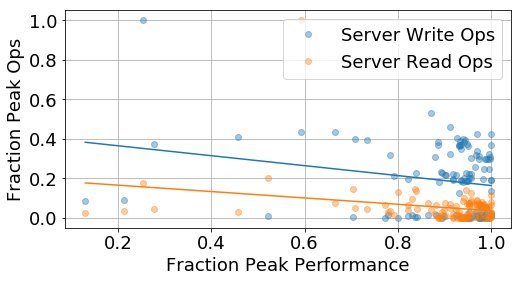

In [23]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

df = df_mira.sort_values(performance_key).copy()

for x_key, y_key in [(performance_key, 'ggio_write_reqs'),
                    (performance_key, 'ggio_read_reqs')]:
    x = df[x_key].values
    y = df[y_key].values / df[y_key].max()
    corr = stats.pearsonr(x, y)
    print counter_labels.get(y_key, y_key), corr[0], corr[1]
    points = ax.plot(x, y,
                     'o',
                     alpha=0.4,
                     markersize=6.0,
                     label="%s" % (counter_labels.get(y_key, y_key))
                    )
        
    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
ax.set_xlabel(counter_labels.get(x_key, x_key))
ax.set_ylabel("Fraction Peak Ops")
ax.legend()
plt.grid(True)
output_file = "scatter_mira_ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Coverage Factor (IOPs) 0.335326162203 0.000205738220761
Saved scatter_mira_ops.pdf


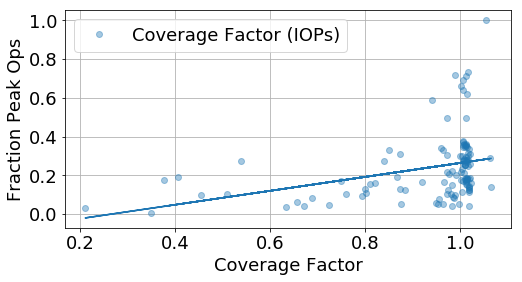

In [24]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

df = df_mira.sort_values(performance_key).copy()

for x_key, y_key in [('coverage_factor', 'iops_coverage_factor')]:
    x = df[x_key].values
    y = df[y_key].values / df[y_key].max()
    corr = stats.pearsonr(x, y)
    print counter_labels.get(y_key, y_key), corr[0], corr[1]
    points = ax.plot(x, y,
                     'o',
                     alpha=0.4,
                     markersize=6.0,
                     label="%s" % (counter_labels.get(y_key, y_key))
                    )
        
    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
ax.set_xlabel(counter_labels.get(x_key, x_key))
ax.set_ylabel("Fraction Peak Ops")
ax.legend()
plt.grid(True)
output_file = "scatter_mira_ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Plot the correlation between coverage factor and performance for each file system separately

Saved scatter_perf-vs-cf_scratch1.pdf
Saved scatter_perf-vs-cf_scratch1.pdf
Saved scatter_perf-vs-cf_scratch1.csv
Saved scatter_perf-vs-cf_scratch2.pdf
Saved scatter_perf-vs-cf_scratch2.pdf
Saved scatter_perf-vs-cf_scratch2.csv
Saved scatter_perf-vs-cf_scratch3.pdf
Saved scatter_perf-vs-cf_scratch3.pdf
Saved scatter_perf-vs-cf_scratch3.csv
Saved scatter_perf-vs-cf_mira-fs1.pdf
Saved scatter_perf-vs-cf_mira-fs1.pdf
Saved scatter_perf-vs-cf_mira-fs1.csv


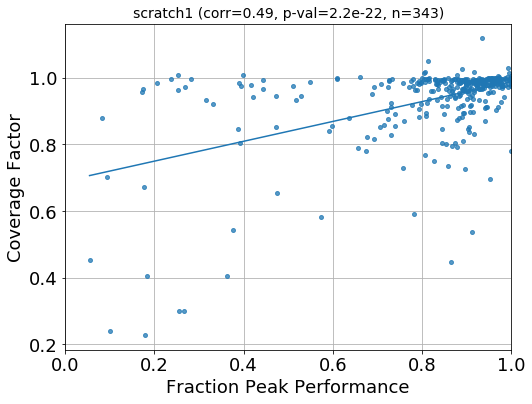

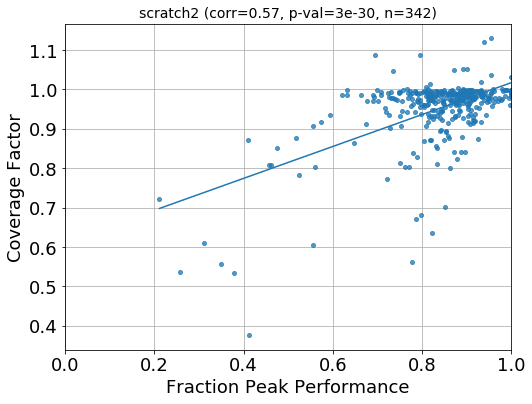

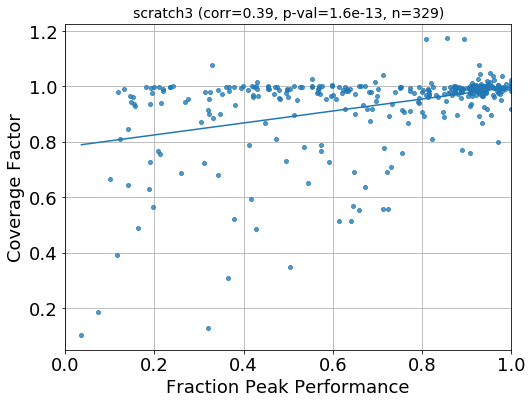

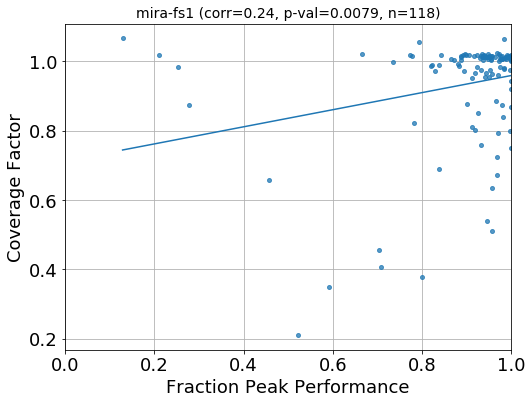

In [25]:
# for scatterplot in correlations_mira:
for idx, fs in enumerate(_FILE_SYSTEM_ORDER):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    x_key = performance_key
    y_key = 'coverage_factor'
    if fs.startswith('mira') :
        df_plot = df_mira.sort_values(performance_key)
        system = "Mira"
    elif fs.startswith('scratch'):
        df_plot = df_edison.sort_values(performance_key)
        system = "Edison"
    else:
        warnings.warn("Cannot find key %s in any data frames" % y_key)
    df_plot = df_plot[df_plot['darshan_file_system'] == fs]
    
    x = df_plot[x_key].values
    y = df_plot[y_key].values
    corr = stats.pearsonr(x, y)
    label = "%s (corr=%.2f, p-val=%4.2g, n=%d)" % (fs, corr[0], corr[1], len(df_plot))
    points = ax.plot(x, y,
                     'o', 
                     alpha=0.75,
                     markersize=4.0)

    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
    ### make the plot pretty
    ax.set_xlim([0.0,2.0 if 'mean' in x_key else 1.0])
    ax.set_ylabel("Coverage Factor")
    ax.set_xlabel(counter_labels[performance_key])
    ax.set_title(label, fontsize=14)
    plt.grid(True)
    output_file = "scatter_perf-vs-cf_%s.pdf" % fs
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file
    fig.savefig(output_file.replace('pdf', 'png'), bbox_inches="tight")
    print "Saved %s" % output_file
    df_save = pandas.DataFrame({"Performance Relative to Mean": x,
                                "Coverage Factor": y}).to_csv(output_file.replace('pdf', 'csv'))
    print "Saved", output_file.replace('pdf', 'csv')

## Distribution of each benchmark type

Following cell defines which variable we wish to aggregate into boxplots and a few plotting parameters that depend on our choice of variable.

In [26]:
boxplot_settings = {
    'fontsize': 15,
    'darshan_normalized_perf_by_fs_max': {
        'output_file': "perf-boxplots-per-fs.pdf",
        'ylabel': "Fraction of Peak\nFile System Performance",
        'title_pos': [ 
            {'x': 0.97, 'y': 0.80, 'horizontalalignment': 'right', 'fontsize': 14},
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14}]
    },
    'darshan_normalized_perf_by_max': {
        'output_file': "perf-boxplots.pdf",
        'ylabel': "Fraction of Peak Performance",
        'title_pos': [ 
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14},
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14}]
    },
}

We plot two sets of boxplots based on the normalization denominator:

1. normalized by the maximum without any grouping (other than file system)
2. normalized by the maximum of each unique combination of app-read/write-filemode

The idea is to show that

1. performance variation varies across different file systems and different applications
2. even within an application, the magnitude of performance variation varies with file system

Saved perf-boxplots.pdf
Saved perf-boxplots-per-fs.pdf


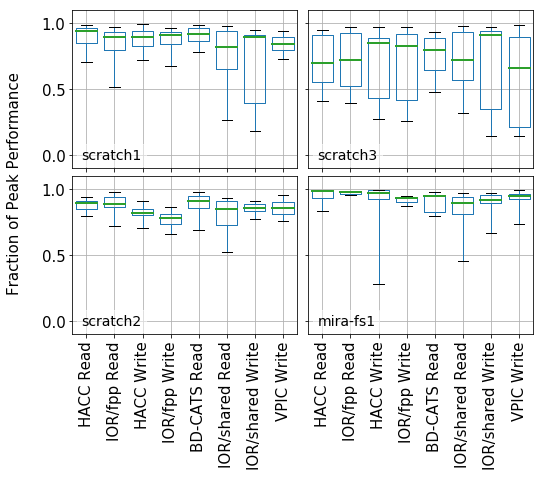

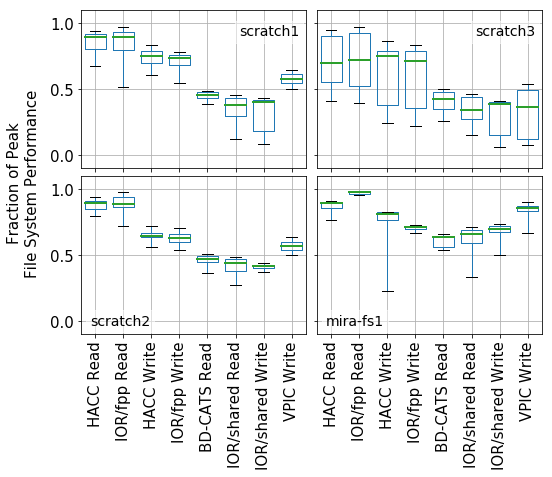

In [27]:
for plot_variable in performance_key, performance_key.replace('_by_', '_by_fs_'):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    fig.set_size_inches(8,6)
    boxplot_group_by = [ 'darshan_file_mode', 'darshan_rw', 'darshan_app' ]
    for idx, fs in enumerate(_FILE_SYSTEM_ORDER):
        icol = idx / 2
        irow = idx % 2
        ax = axes[irow, icol]
        df_concat.loc[df_concat["darshan_file_system"] == fs]\
        .boxplot(
            column=[plot_variable],
            by=boxplot_group_by,
            ax=axes[irow, icol],
            medianprops={'linewidth':2 },
            widths=0.75,
            whis=[5,95],
            showfliers=False)

        settings = boxplot_settings[plot_variable]['title_pos'][irow]
        title = ax.set_title(fs, **(settings))
        title.set_bbox({'color': 'white', 'alpha': 0.5})
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.xaxis.grid(True)

        ### relabel the x axis labels
        new_labels = []
        for axis_label in ax.get_xticklabels():
            current_label = axis_label.get_text()
            axis_label.set_rotation(90)
            if "IOR" in current_label:
                if "shared" in current_label:
                    new_label = "IOR/shared"
                else:
                    new_label = "IOR/fpp"
            elif 'BD-CATS' in current_label:
                new_label = "BD-CATS"
            else:
                new_label = current_label.split(',')[2].strip(')').strip().split('-')[0]
            if 'write' in current_label:
                new_label += " Write"
            else:
                new_label += " Read"
            new_labels.append(new_label)

        ### set x tick labels for only the bottom row
        if irow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(new_labels,
                               fontsize=boxplot_settings['fontsize'])

        ax.yaxis.set_ticks( np.linspace(0.0, 1.0, 3) )
        ax.set_ylim([-0.1, 1.1])
        for ytick in ax.yaxis.get_major_ticks():
            ytick.label.set_fontsize(boxplot_settings['fontsize'])

        
    fig.suptitle("")
    # fig.text(0.5, -0.4, 'common X', ha='center')
    fig.text(0.0, 0.5,
             boxplot_settings[plot_variable]['ylabel'],
             verticalalignment='center',
             horizontalalignment='center',
             rotation='vertical',
             fontsize=boxplot_settings['fontsize'])
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    output_file = boxplot_settings[plot_variable]['output_file']
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file

Also plot a more general overview of performance across each file system.

Saved perf-boxplots-fs.pdf


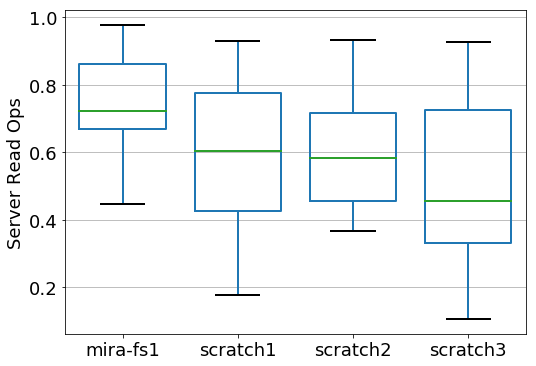

In [28]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
df_concat.boxplot(
    column=[plot_variable],
    by=["darshan_file_system"],
    ax=ax,
    widths=0.75,
    boxprops={'linewidth':2},
    medianprops={'linewidth':2 },
    whiskerprops={'linewidth':2},
    capprops={'linewidth':2},
    flierprops={'linewidth':2},
    whis=[5,95],
    showfliers=False)
### add window dressing to plots
# plt.xticks(rotation=45)
fig.suptitle("")
ax.set_title("", fontsize=14 )
ax.set_xlabel("")
ax.set_ylabel(y_label)
ax.xaxis.grid(False)

output_file = "perf-boxplots-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Also create a boxplot of the coverage factor to demonstrate how often jobs were impacted by other jobs

Saved cf-boxplots-fs.pdf


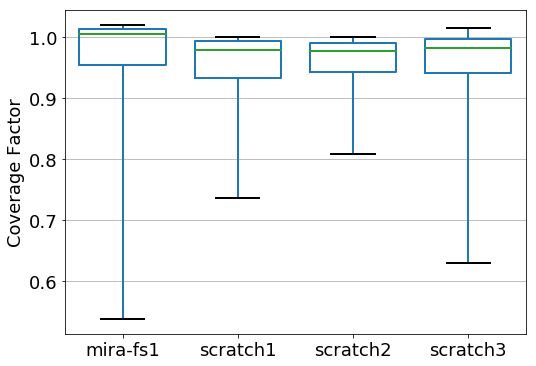

In [29]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
df_concat.boxplot(
    column=['coverage_factor'],
    by=["darshan_file_system"],
    ax=ax,
    widths=0.75,
    boxprops={'linewidth':2},
    medianprops={'linewidth':2 },
    whiskerprops={'linewidth':2},
    capprops={'linewidth':2},
    flierprops={'linewidth':2},
    whis=[5,95],
    showfliers=False)
### add window dressing to plots
# plt.xticks(rotation=45)
fig.suptitle("")
ax.set_title("", fontsize=14 )
ax.set_xlabel("")
ax.set_ylabel("Coverage Factor")
ax.xaxis.grid(False)

output_file = "cf-boxplots-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Also try a coverage factor histogram since boxplots don't represent the long tail very well.

Saved cf-histogram-fs.pdf


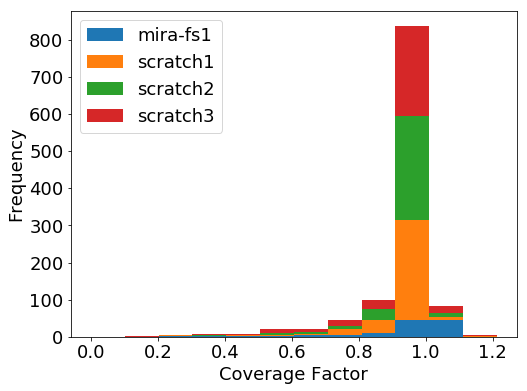

In [30]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

x = []
labels = []
for fs in df_concat['darshan_file_system'].unique():
    x.append(df_concat[df_concat["darshan_file_system"]==fs]["coverage_factor"].reset_index(drop=True).dropna())
    labels.append(fs) # in case the .unique() generator is nondeterministic
    
### retain the histogram results
histogram = ax.hist(x,
        bins=[0.101 * x for x in range(0,13)],
        label=labels,
        stacked=True
    )
# ax.yaxis.grid()
ax.legend()
ax.set_title("", fontsize=14 )
ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Frequency")
fig.suptitle("")

output_file = "cf-histogram-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Calculate the cumulative distribution function (CDF) from the histogram data to get a probability distribution of observing a given coverage factor (CF).

In [31]:
for i in range(len(histogram[0])): # 4
    sums = [0 for x in range(len(histogram[0][i]))]
    for j in range(len(histogram[0][i])): # 13
        sums[j] += histogram[0][i][j]
probabilities = sums / sum(sums)
cumul = 0.0
print "%5s %6s %10s %10s" % ("CF", "Value", "CDF", "1-CDF")
for idx, probability in enumerate(probabilities):
    cumul += probability
    print "%5.3f %6.4f %10.4f %10.4f" % ( histogram[1][idx], probability, cumul, 1.0 - cumul )

   CF  Value        CDF      1-CDF
0.000 0.0000     0.0000     1.0000
0.101 0.0027     0.0027     0.9973
0.202 0.0044     0.0071     0.9929
0.303 0.0062     0.0133     0.9867
0.404 0.0062     0.0194     0.9806
0.505 0.0177     0.0371     0.9629
0.606 0.0194     0.0565     0.9435
0.707 0.0389     0.0954     0.9046
0.808 0.0875     0.1829     0.8171
0.909 0.7394     0.9223     0.0777
1.010 0.0724     0.9947     0.0053
1.111 0.0053     1.0000     0.0000


## Cumulative Distribution Functions

We now have a distribution for the coverage factor and performance.  What is the probability of getting anywhere near peak performance?  How does this vary with the coverage factor?

First calculate the cumulative distribution function for keys of interest:

In [32]:
def calculate_cdf( values ):
    """Create a pandas.Series that is the CDF of a list-like object"""

    denom = len(values) - 1
    x = sorted(values / values.max())
    y = [ i / denom for i in np.arange(len(x), dtype=np.float64) ]
    return pandas.Series( y, index=x )

In [33]:
### Calculate CDFs for (1) each file system and (2) performance and coverage factor
cdfs = {}
for fs in _FILE_SYSTEM_ORDER:
    df_fs = df_concat[df_concat['darshan_file_system'] == fs]
    for cdf_key in 'darshan_normalized_perf_by_max', 'coverage_factor':
        if cdf_key not in cdfs:
            cdfs[cdf_key] = {}
        cdf = calculate_cdf(df_fs[cdf_key])
        cdfs[cdf_key][fs] = {
            'dependent_variable':  cdf.index,
            'probability': cdf.values,
        }

In [34]:
### don't use counter_labels because the context is slightly different
cdf_labels = {
    'darshan_normalized_perf_by_max': "Fraction Peak Performance",
    'coverage_factor': "Coverage Factor",
}
cdf_file_labels = {
    'darshan_normalized_perf_by_max': "perf",
    'coverage_factor': "coverage-factor",
}

Saved cdf-both.pdf


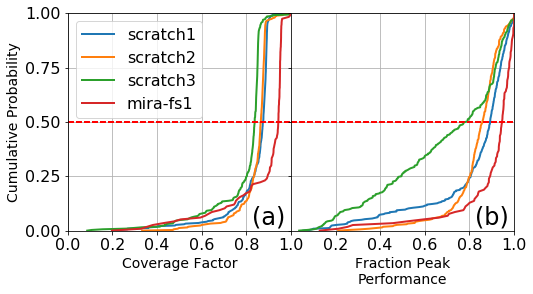

In [35]:
### Plot CDF side-by-side

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8,4)

for fs in _FILE_SYSTEM_ORDER:
    for idx, cdf_key in enumerate(sorted(cdfs.keys())):
        axes[idx].plot(
                       cdfs[cdf_key][fs]['dependent_variable'],
                       cdfs[cdf_key][fs]['probability'],
                       label=fs,
                       linewidth=2)
        axes[idx].set_xlabel(wrap(cdf_labels[cdf_key]), fontsize=14)
        axes[idx].set_ylabel("")
        axes[idx].plot([0.0, 1.0],[0.5, 0.5], '--', linewidth=2.0, color='red')
        axes[idx].legend().remove()
#       axes[idx].set_xticks([0.0, 0.25, 0.50, 0.75, 1.0])
        axes[idx].set_xticks(np.linspace(0.0, 1.0, 6))
        for tick in axes[idx].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axes[idx].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
axes[1].xaxis.get_major_ticks()[0].set_visible(False)
axes[0].set_title('(a)', position=(0.90,0.0), fontsize=24)
axes[1].set_title('(b)', position=(0.90,0.0), fontsize=24)
#fig.legend(
axes[0].legend(
    *(axes[0].get_legend_handles_labels()),
    fontsize=16
#   ncol=4,
#   mode="expand",
#   bbox_to_anchor=(0.11, 0.0, 0.79, 1.0),
#   loc="upper left",
#   borderaxespad=0.0
          )
axes[0].set_ylabel("Cumulative Probability", fontsize=14)
for i in 0, 1:
    axes[i].set_ylim([0.0, 1.0])
    axes[i].set_xlim([0.0, 1.0])
    axes[i].grid(True)
    axes[i].yaxis.set_ticks([0.0,0.25,0.50,0.75,1.0])
fig.suptitle("")
# fig.text(0.0, 0.5, "Cumulative Probability", va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.0, wspace=0.0)

output_file = "cdf-both.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

In [36]:
### The 99th percentile of Mira's coverage factors:
# np.percentile( df_concat[df_concat['system'] == 'mira']['coverage_factor'], 99 )

target_value = 0.99
print "Coverage factor of %.2f or higher corresponds to the %.2fth percentile" % (
    target_value,
    stats.percentileofscore(df_concat[df_concat['system'] == 'mira']['coverage_factor'], target_value) )

Coverage factor of 0.99 or higher corresponds to the 40.68th percentile


In [37]:
descriptions = {
    'darshan_normalized_perf_by_max': "On %s, %4.1f%% of jobs got below %d%% peak performance",
    'coverage_factor': "On %s, %4.1f%% of jobs got a coverage factor below %d%%",
}
target_fraction = 0.99
### Back up the caption used in the paper for the above CDF plot
for cdf_key in 'darshan_normalized_perf_by_max', 'coverage_factor':
    for fs in _FILE_SYSTEM_ORDER:
        df_fs = df_concat[df_concat['darshan_file_system'] == fs]
        value = scipy.interpolate.interp1d(
            cdfs[cdf_key][fs]['dependent_variable'],
            cdfs[cdf_key][fs]['probability'])(target_fraction)
        print descriptions[cdf_key] % (fs, 100.0 * value, int(100.0 * target_fraction))

On scratch1, 95.3% of jobs got below 99% peak performance
On scratch2, 96.9% of jobs got below 99% peak performance
On scratch3, 96.7% of jobs got below 99% peak performance
On mira-fs1, 87.1% of jobs got below 99% peak performance
On scratch1, 100.0% of jobs got a coverage factor below 99%
On scratch2, 99.7% of jobs got a coverage factor below 99%
On scratch3, 99.4% of jobs got a coverage factor below 99%
On mira-fs1, 98.3% of jobs got a coverage factor below 99%


In [38]:
print "The line demarcing 50% probability corresponds to..."

target_fraction = 0.50
### Back up the caption used in the paper for the above CDF plot
for cdf_key in 'darshan_normalized_perf_by_max', 'coverage_factor':
    for fs in _FILE_SYSTEM_ORDER:
        df_fs = df_concat[df_concat['darshan_file_system'] == fs]
        value = scipy.interpolate.interp1d(
            cdfs[cdf_key][fs]['probability'],
            cdfs[cdf_key][fs]['dependent_variable']
        )(target_fraction)
        print fs, cdf_key, value

The line demarcing 50% probability corresponds to...
scratch1 darshan_normalized_perf_by_max 0.892100374352
scratch2 darshan_normalized_perf_by_max 0.857671384799
scratch3 darshan_normalized_perf_by_max 0.782941310302
mira-fs1 darshan_normalized_perf_by_max 0.945916094003
scratch1 coverage_factor 0.874945132221
scratch2 coverage_factor 0.864725179181
scratch3 coverage_factor 0.837441650138
mira-fs1 coverage_factor 0.9438239125


## IOPS Coverage Factor

In [39]:
df = df_mira.copy()
df['iops_coverage_factor'] = (df_mira['darshan_total_rws'] / (df_mira['ggio_read_reqs'] + df_mira['ggio_write_reqs']))


When performance is high, iops coverage factor is high (so application has exclusive access to iops)
When performance is low, iops coverage factor is low



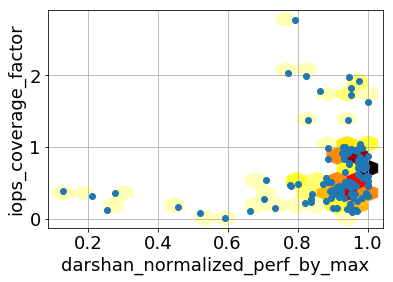

In [40]:
fig = plt.figure()
ax = fig.add_subplot('111')
x_counter = 'coverage_factor'
x_counter = 'darshan_normalized_perf_by_max'
y_counter = 'iops_coverage_factor'
ax.plot(df[x_counter],
        df[y_counter],
        marker='o',
        alpha=1.0,
        linewidth=0.0,
       )
result = ax.hexbin( df[x_counter],
            df[y_counter],
            gridsize=15,
            cmap='hot_r'
       )

ax.set_xlabel(x_counter)
ax.set_ylabel(y_counter)
ax.grid()
print """
When performance is high, iops coverage factor is high (so application has exclusive access to iops)
When performance is low, iops coverage factor is low
"""

Saved cdf-cf-bw-and-ops.pdf
Saved hist-cf-bw-and-ops.pdf


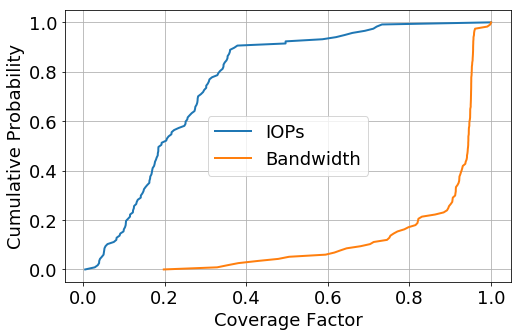

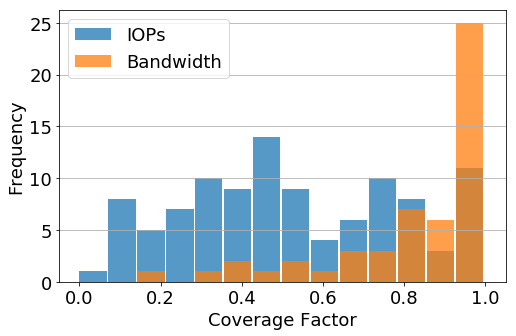

In [41]:
### CDF
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_subplot("111")
ax.plot(calculate_cdf( df_mira['iops_coverage_factor'] ), label='IOPs', lw=2.0)
ax.plot(calculate_cdf( df_mira['coverage_factor'] ), label='Bandwidth', lw=2.0)
ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Cumulative Probability")
ax.legend()
ax.grid()
output_file = "cdf-cf-bw-and-ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file


### Also try bar plots
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_subplot("111")
y1 = df_mira['iops_coverage_factor']
y2 = df_mira['coverage_factor']
common_opts = {
                "width": 1.0/15.0,
                "bins": np.linspace(0.0, 1.0, 15),
                'alpha': 0.75,
                'lw': 3.0,
#                 'zorder': 9,
              }

# ax.hist( [ y1, y2 ], label=["IOPs", "Bandwidth"], **common_opts)
for y, label in [ 
                 (y1, 'IOPs'),
                 (y2, 'Bandwidth'),

                ]:
    ax.hist( y, label=label, **common_opts)

ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Frequency")
ax.legend()
ax.yaxis.grid()
output_file = "hist-cf-bw-and-ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Saved hist-cf-bw-scratch1.pdf
Saved hist-cf-bw-scratch2.pdf
Saved hist-cf-bw-scratch3.pdf


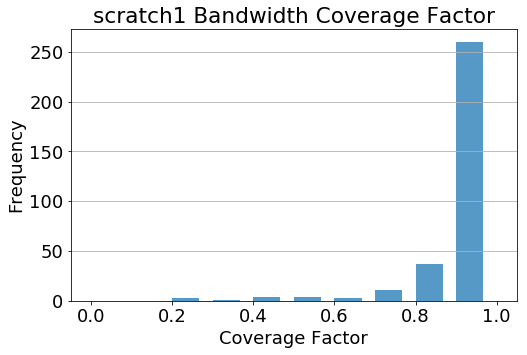

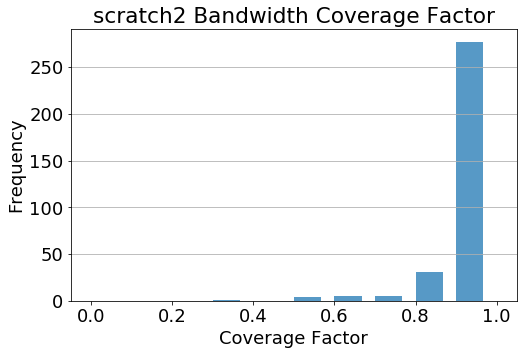

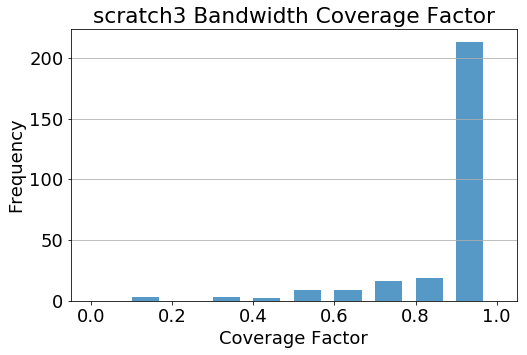

In [42]:
### Also try bar plots for Edison

for fs in df_concat[df_concat['system'] == 'edison']['darshan_file_system'].unique():
    fig = plt.figure()
    fig.set_size_inches(8,5)
    ax = fig.add_subplot("111")
    y = df_concat[df_concat['darshan_file_system'] == fs]['coverage_factor']
    common_opts = {
                    "width": 1.0/15.0,
                    "bins": np.linspace(0.0, 1.0, 11),
                    'alpha': 0.75,
                    'lw': 3.0,
                  }
    ax.hist( y, label='Bandwidth', **common_opts)

    ax.set_xlabel("Coverage Factor")
    ax.set_ylabel("Frequency")
#   ax.legend()
    ax.yaxis.grid()
    ax.set_title("%s Bandwidth Coverage Factor" % fs)
    output_file = "hist-cf-bw-%s.pdf" % fs
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file

## Identifying Statistical Distribution of Problem Sources

The idea here is that we look at the bottom quartile of performance across all apps and see if there are any common threads of correlation.  For example, some by-hand poking at Mira data revealed that readdirs were usually high when performance was low.  PCA would be a better way to do this, but who has time to do that?

In [ ]:
worst_runs_index = {}
for system in 'edison', 'mira':
    sys_index = df_concat[df_concat['system'] == system].index
    perf_index = (df_concat.loc[sys_index] < np.percentile(df_concat.loc[sys_index], 25)).index
    worst_runs_index[system] = perf_index